# Chimera Movie Recommendations

## Overview

The new movie streaming service 'Cinemania' is looking for a way to increase movie streaming by customers. They have asked Chimera Solutions to provide the means of connecting subscribers to movies that they will enjoy, and then link to them to other movies that they will enjoy. The goal of this notebook is to construct a recommendation system that will accurately link subscribers to movies that fit their unique tastes.

## Business Problem

Cinemania is trying to enter the highly saturated streaming service field, and is looking for the means to level the playing field. They need a recommendation system that is accurate enough to give users a reason to use their service over the many other ones.

- __Stakeholder:__ Cinemania


- __Significance of Recommendations:__ Recommendations need to be accurate so that users keep watching more and more movies on the stakeholder's streaming service


- __Deliverable:__ An interpretable Recommendation Model that the stakeholder can easily understand



## Notebook Summary 

## Exploratory Data Analysis

We first collect and examine the dataset given to us. We have 4 datasets, consisting of the movies, ratings, movie links, and tags. Ratings and movies are the only ones we use in our modelling. Given the ratings dataset invaluable information on user ratings, it does most of the predictive work. We use the movies dataset for its information on genres to help with our cold start problem, ie. when we have a new user with no previous preference information.

In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from surprise import SVD, SVDpp, NMF, NormalPredictor, KNNBaseline, KNNBasic,\
KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, SlopeOne

from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import train_test_split as sur_tts
from surprise import similarities 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
links = pd.read_csv('data/links.csv')
tags = pd.read_csv('data/tags.csv')

#### Movies Dataset Analysis 

There are a collective 9,742 available movies in Cinemania's platform.

In [3]:
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Great! no missing values in this dataset

In [5]:
print(movies['movieId'].nunique())
print(movies['title'].nunique())

9742
9737


There are 5 duplicated Movie titles, but that is not a big deal for what we are trying to accomplish

#### Ratings Dataset Analysis

There are over 100,000 user ratings in the dataset. The ratings dataset has the userId, movieId, rating, and timestamp of the rating. 

In [6]:
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


No missing values in our ratings datset, duplicates are expected here because one user can rate multiple movies, and a movie can be rated by multiple users.

<AxesSubplot:>

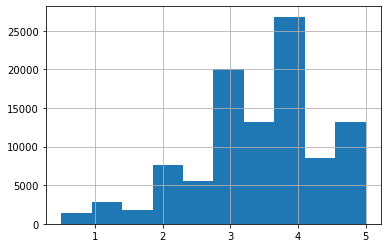

In [8]:
ratings['rating'].hist()

There seems to be a slightly skewed distribution of ratings, but this is just how users rated their movies, so this will be left as is.

In [9]:
users = ratings['userId'].nunique()
movie = ratings['movieId'].nunique()

In [10]:
print(f'There are {users} users rating {movie} movies')

There are 610 users rating 9724 movies


We have way more movies than users which is to be expected with a new streaming service. 

#### Tags Dataset Analysis

This dataset consists of user comments on shows they watched. It can be linked to the ratings as the userId and movieId are both given. There are only 3000 comments out of over 100000 ratings, so it cannot be used broadly even if NLP could be an intriguing options.

In [11]:
print(tags.shape)
tags.head()

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [12]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


No missing values and the tag column is just a user generated phrase describing something that stood out to them in the movie.

#### Links Dataset Analysis 

These are ID numbers that provide links to the actual movies on imdb.com and The Movie Database. 

In [13]:
print(links.shape)
links.head()

(9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [14]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


This data is not needed for our recommendation system, we want users to watch movies on Cinemania's Streaming Service.

##### Data for our recommendation system

In [15]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [16]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We are going to use the __ratings__ dataset to produce recommendations to users based on what similar users have rated highly, and we are going to use the title and genre columns from the __movies__ dataset to make the output of of our model more interpretable by using the title rather than the movieId. 

#### Data Preprocessing

Given the high number of movies with only a few reviews (<=10), we decided to remove those ratings so our model would provide more accurate and confident recommendations. This results in a reduction of 20,000 ratings.

In [17]:
print(len(ratings.index))
unique_movies = ratings['movieId'].unique()

movie_count = {}

for i in unique_movies:
    movie_count[i]= 0
    
for i in ratings['movieId']:
    movie_count[i] += 1

rare_movies = []
for movie in movie_count.keys():
    if movie_count[movie] <= 10:
        rare_movies.append(movie)
        
to_delete = []
for index, row in ratings.iterrows():
    if row.movieId in rare_movies:
        to_delete.append(index)
        
ratings.drop(to_delete,inplace=True)
print(len(ratings.index))


100836
79636


now the number of ratings that we will use in our model is 79636

In [18]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

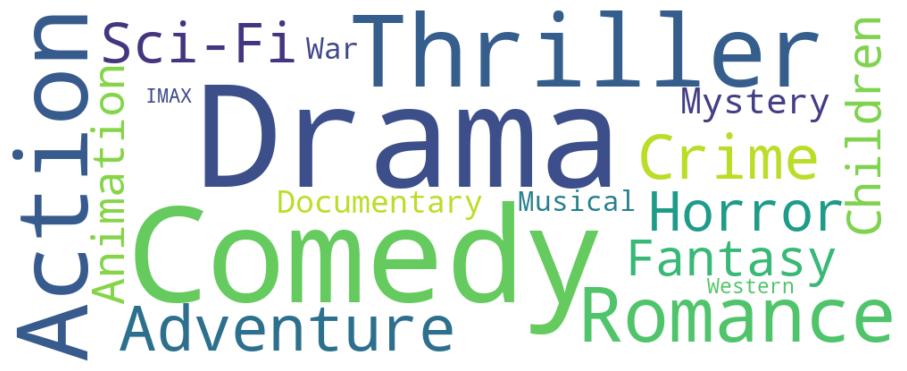

In [19]:
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Modeling

For our modelling, we will be using the Surprise library's machine learning and recommendations toolkit.

#### Compare Different Baseline Models

In [20]:
rating_data = ratings.drop('timestamp', axis=1)

In [21]:
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(rating_data, reader=reader)

By running this algorithm, we can iterrate over all the potential models in the Surprise library and determine which model minimizes loss. We used RMSE to measure loss.

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation to see which algorithms give lowest RMSE
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Create a dataframe with the algorithm as the index
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

SVDpp, BaselineOnly, SVD, and KNNBaseline are our top 4 models with default parameters. SVDpp is only a point better but is significantly computationally expensive than the other 3 seeing that it took a total of 419 seconds(7 minutes) to fit and test.

### Model Tuning

#### Split our data into Training and Test sets and fit the best performing models on the training set.

In [22]:
#use sklearn library train test split
y = pd.DataFrame(rating_data['rating'])
X= rating_data.drop('rating',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y)

#remerge to convert using reader

train_df = pd.concat([X_train,y_train],axis=1)

test_df = pd.concat([X_test,y_test],axis=1)

#convert to surprise dataframes
trainset= Dataset.load_from_df(train_df, reader=reader)

testset = Dataset.load_from_df(test_df, reader=reader)


# make testset data usable for testing
# We loaded in surprise's Train Test Split as sur_tts, so that it doesn't get mixed up with the sklearn version
# This method of using sklearn's train test split and then surprises was our way of getting grid searches to work
# Sorry for the complicataions

blank,testset = sur_tts(testset, test_size=.99)

type(testset)

list

In [23]:
# for some odd reason the surprise library gives an error when fitting unless I run this code to build a full trainset
# out of the trainset that we already got from the split
train_set = trainset.build_full_trainset()

##### KNNBaseline

We decided to find user based similarities because there are 610 users, and about a 100,000 items so comparing users makes alot more sense than comparing 100,000 items.

In [24]:
sim_pearson = {'name':'pearson', 'user_based':True}
knn_baseline = KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(train_set)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [25]:
knn_predictions = knn_baseline.test(testset)
print(accuracy.rmse(knn_predictions))
print(accuracy.mae(knn_predictions))

RMSE: 0.8421
0.8421303280510913
MAE:  0.6422
0.642213470474036


Now we will try this model using cosine as our similarity metric

In [26]:
sim_cos = {'name':'cosine', 'user_based':True}
knn_baseline_cos = KNNBaseline(sim_options=sim_cos)
knn_baseline_cos.fit(train_set)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [27]:
knn_cos_predictions = knn_baseline_cos.test(testset)
print(accuracy.rmse(knn_cos_predictions))
print(accuracy.mae(knn_cos_predictions))

RMSE: 0.8407
0.8406745631071322
MAE:  0.6423
0.6423362254709162


Switching to cosine slightly dropped our error, not much of an improvement 

##### BaselineOnly with gridsearch 

In [28]:
baseline_param_grid = {'bsl_options':{'method':
['als', 'sgd'], 'n-epochs': [5, 15, 30], 
'lr_all': [0.002, 0.005, 0.01],'reg_all': [0.01, 0.2, 0.4, 0,6]}}

In [29]:
gs_base = GridSearchCV(BaselineOnly,baseline_param_grid,measures=['rmse'],cv=3,n_jobs=-1)
gs_base.fit(trainset)

base_params = gs_base.best_params['rmse']

base_params

{'bsl_options': {'method': 'sgd',
  'n-epochs': 5,
  'lr_all': 0.002,
  'reg_all': 0.01}}

In [30]:
base = BaselineOnly(bsl_options = {'method': 'sgd',
  'n-epochs': 5,
  'lr_all': 0.002,
  'reg_all': 0.01})
base.fit(train_set)

base_preds = base.test(testset)
print(accuracy.rmse(base_preds))
print(accuracy.mae(base_preds))

Estimating biases using sgd...
RMSE: 0.8428
0.842816463491527
MAE:  0.6445
0.6444956124430625


The BaselineOnly model had a higher error than the KNNBaseline model, so we will stick with our KNN model for now

In [31]:
# use a gridsearch to find best params for SVD
param_grid = {'n_factors':[50,200,250],'n_epochs':[25,30,40],
              'lr_all':[.025,.05,.075],'reg_all':[.04,.05,.06]}

gs_svd = GridSearchCV(SVD,param_grid,measures=['rmse'],cv=3,n_jobs=-1)
gs_svd.fit(trainset)

params = gs_svd.best_params['rmse']

params

{'n_factors': 250, 'n_epochs': 40, 'lr_all': 0.025, 'reg_all': 0.06}

In [33]:
#test best SVD on testset

algo = SVD(n_factors= 250, n_epochs=40, lr_all= 0.025, reg_all= 0.06)

train_set = trainset.build_full_trainset()
algo.fit(train_set)

preds = algo.test(testset)

accuracy.rmse(preds)
accuracy.mae(preds)

RMSE: 0.8254
MAE:  0.6304


0.6303610318150848

## Final Model Evaluation

- As seen above a model that gives us an MAE of .63 would predict a rating that .63 higher or .63 lower than the true rating given by a user.

## Cold Start Problem

In order to use this model we have to already have information about the user's preferences. In this part of the notebook we use pandas correlation functionality to generate recommendations for brand new subscribers based on genre correlation.

In [43]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [44]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We begin by merging these 2 tables to get titles and ratings in the same dataframe.

In [45]:
data = ratings.merge(movies, on='movieId')

In [46]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [47]:
data.shape

(79636, 6)

Here we get the average rating for each movie

In [48]:
average_ratings = pd.DataFrame(data.groupby('title')['rating'].mean())
average_ratings.head(10)

,rating
title,
"'burbs, The (1989)",3.176471
(500) Days of Summer (2009),3.666667
10 Cloverfield Lane (2016),3.678571
10 Things I Hate About You (1999),3.527778
"10,000 BC (2008)",2.705882
101 Dalmatians (1996),3.074468
101 Dalmatians (One Hundred and One Dalmatians) (1961),3.431818
12 Angry Men (1957),4.149123
12 Years a Slave (2013),3.625000


Now we add a column to display the number of times each movie has been rated 

In [49]:
average_ratings['total ratings'] = pd.DataFrame(data.groupby('title')['rating'].count())
average_ratings.head()

,rating,total ratings
title,,
"'burbs, The (1989)",3.176471,17
(500) Days of Summer (2009),3.666667,42
10 Cloverfield Lane (2016),3.678571,14
10 Things I Hate About You (1999),3.527778,54
"10,000 BC (2008)",2.705882,17


##### Create a ratings table
- Index = The Users
- Columns = The Movies
- The Values = Ratings

In [50]:
user_ratings = data.pivot_table(index='userId',columns='title',values='rating')
user_ratings.head(15)

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


There are so many movies in the world, most individuals are not expected to have rated or to even have watched every movie out there.

In [51]:
import warnings

warnings.filterwarnings('ignore')

The following function gives us an annoying warning so we use this import to clean up this part of the notebook

In [52]:
def new_user_recommendations(input, n=5):
    
    # Find movies that have a high correlation with the movie that the user selected    
    correlations = user_ratings.corrwith(user_ratings[input])
    
    # Build a new Dataframe that has 
    recommendations = pd.DataFrame(correlations,columns=['correlation'])
    
    # Drop rows with missing ratings
    recommendations.dropna(inplace=True)
    
    # Join the Num Ratings columns so that customers can see how many ratings a movie recieved
    recommendations = recommendations.join(average_ratings['total ratings'])
    
    # Select movies with more than 100 ratings, and put the highest correlated movies at the top
    user_recs = recommendations[recommendations['total ratings']>100].sort_values('correlation',ascending=False).reset_index()
    
    # merge this dataframe with our original movies dataframe
    user_recs = user_recs.merge(movies,on='title')
    
    # Drop first row so that the movie that was entered does not appear in recommendations
    user_recs = user_recs.iloc[1: , :]
    
    user_recs['correlation'] = user_recs['correlation'].round(decimals = 2)
    return user_recs.head(n)

In [53]:
# Men in Black (a.k.a. MIB) (1997) Aladdin (1992), Star Trek: Generations (1994), X-Men (2000)
# The titles have to be exact for this function to work as of now, so you can copy and paste one of the above titles
new_user_recommendations(input())

Aladdin (1992)


,title,correlation,total ratings,movieId,genres
1,Toy Story (1995),0.61,215,1,Adventure|Animation|Children|Comedy|Fantasy
2,"Lion King, The (1994)",0.59,172,364,Adventure|Animation|Children|Drama|Musical|IMAX
3,Beauty and the Beast (1991),0.58,146,595,Animation|Children|Fantasy|Musical|Romance|IMAX
4,"Truman Show, The (1998)",0.56,125,1682,Comedy|Drama|Sci-Fi
5,Finding Nemo (2003),0.54,141,6377,Adventure|Animation|Children|Comedy


now we get a list of 5 movies that have the highest genre correlation with the movie that the new subscriber submitted.  After this first elementary recommendation, we can use the users rating on this first movie to generate more accurate predictions based on their similarity with other users.

## Conclusion 

We were able to create a recommendation model that can predict what a user will rate a movie while only being off by .64 of the true rating. We would like to drop our error down to .5, a task that we can definitely get to after obtaining more user data.   

### Future Work

- Implement user written reviews into our recommendation model to find more similarities between users


- Eliminate watched movies from user's recommendations


- Implement Neural networks into our recommendation system to make our recommendation system more accurate

